## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [ ]:
!pip uninstall --yes gdown
!pip install gdown -U --no-cache-dir

Found existing installation: gdown 4.7.3
Uninstalling gdown-4.7.3:
  Successfully uninstalled gdown-4.7.3


In [ ]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO

but Gdown can't. Please check connections and permissions.


In [ ]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Downloading...
From (original): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW
From (redirected): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW&confirm=t&uuid=5aca857a-e808-4ec1-a33f-7fef92ef0f96
To: /content/coco_captions.npy
100% 415M/415M [00:03<00:00, 132MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.jpg  
 extracting: val2014/COCO_val2014_000000161308.jpg  
 extracting: val2014/COCO_val2014_000000153013.jpg  
 extracting: val2014/COCO_val2014_000000089924.jpg  
 extracting: val2014/COCO_val2014_000000289842.jpg  
 extracting: val2014/COCO_val2014_000000191226.jpg  
 extracting: val2014/COCO_val2014_000000157465.jpg  
 extracting: val2014/COCO_val2014_000000218224.jpg  
 extracting: val2014/COCO_val2014_000000030548.j

In [86]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np

In [87]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [88]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [89]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [90]:
cap_path = '/content/drive/MyDrive/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [91]:
img_path = '/content/drive/MyDrive/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


# Part 1: Implement the algorithm and compute the bleu score

In [92]:
# Train test split
import pandas as pd
from sklearn.model_selection import train_test_split

img_train, img_test, captions_train, captions_test, indices_train, indices_test = train_test_split(image_embeddings, caption_embeddings, range(len(image_embeddings)), test_size=0.2)

In [93]:
def get_query_vector(neigh, k):
    res = np.zeros((512))

    for dist, indx in neigh:
        res += ((1-dist)/(k*5)) * np.sum(captions_train[int(indx)], axis=0)

    return res

In [94]:
def get_caption(train_dist, index):
    res = 1
    query_caption = None

    for i in index:
        i = int(i)
        dot_products = np.dot(captions_train[i], train_dist)
        norms = np.linalg.norm(captions_train[i], axis=1)
        cal = dot_products / (norms * np.linalg.norm(train_dist))

        min_cal_index = np.argmin(np.abs(cal))

        if abs(cal[min_cal_index]) < res:
            res = abs(cal[min_cal_index])
            query_caption = [indices_train[i], min_cal_index]

    return query_caption


In [95]:
def accuracy_v2(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    lower_n_split = lambda x: x.lower().split()

    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre))
        accuracy += score
    return accuracy/len(predict)

In [96]:
# K neighbours
def image_captioning(k_param=3, mode='knn'):
  k = k_param
  if mode == 'knn':
    k_neighbours = np.transpose(np.array(list(faiss.knn(img_test, img_train, k))), [1, 2, 0])

  elif mode == 'index_flat_ip':
    index = faiss.IndexFlatIP(image_embeddings.shape[1])
    index.add(img_train)
    k_neighbours = np.transpose(np.array(list(index.search(img_test, k))), [1, 2, 0])

  elif mode == 'index_hnsw_flat':
    index = faiss.IndexHNSWFlat(image_embeddings.shape[1], 16)
    index.add(img_train)
    k_neighbours = np.transpose(np.array(list(index.search(img_test, k))), [1, 2, 0])


  query_vector = []

  for it in k_neighbours:
    train_dist = get_query_vector(it, k)
    query_caption = get_caption(train_dist, it.T[1])

    query_vector.append(query_caption)

  predicted_captions = []
  actual_captions = []

  for i in range(len(query_vector)):
    img, target_caption = coco_dset[indices_test[i]]
    actual_captions.append(target_caption)
    predicted_captions.append(captions[query_vector[i][0]][query_vector[i][1]])

  return [query_vector, predicted_captions, actual_captions]

In [97]:
import matplotlib.pyplot as plt

def visualize_img(z):
  img, target = coco_dset[indices_test[z]]
  img_array = np.transpose(img, (1,2,0))

  plt.imshow(img_array)
  print(target)
  print(captions[query_vector[z][0]][query_vector[z][1]])
  plt.show()

In [98]:
query_vector, predicted_captions, actual_captions = image_captioning()
visualize_img(675)

# Part 2: Trying out different values of k and checking their bleu score


In [100]:
ks = []
blue_score = []

for i in range(1, 10):
  query_vector, predicted_captions, actual_captions = image_captioning(k_param=i)

  ks.append(i)
  blue_score.append(accuracy_v2(predicted_captions, actual_captions))

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

KeyboardInterrupt: 

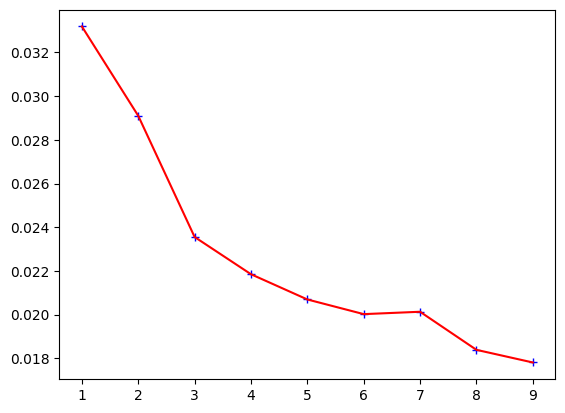

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ks, blue_score, 'b+')
plt.plot(ks, blue_score, 'red')
plt.show()

## Observations:
- As k value is increasing, the bleu score keeps on decreasing

# Part 3: Visualizing 5 images

['people crossing a zebra crossing and vehicles standing', 'Pedestrian crosswalk at city intersection with one white car stopped for light while four pedestrians cross the street where multiple newspaper boxes are on the corner.', 'A group of people crossing a street near a traffic light.', 'People walk across a street during the day.', 'Pedestrians cross at a crosswalk in a crowded city.']
A man in blue shirt on skateboard next to cars.


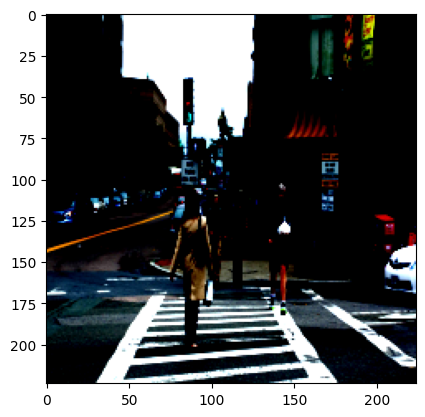

['A woman standing in a kitchen preparing food.', 'A woman in red hoodie standing next to a cake on cooling rack.', 'A woman smiles while standing next to a cake on the stove.', 'A lady making something in a home kitchen of some sort.', 'A young woman has just made a cake she gives a thumbs-up to as sme smiles at the camera. ']
A woman with glasses wearing an orange t-shirt stands in a kitchen area.


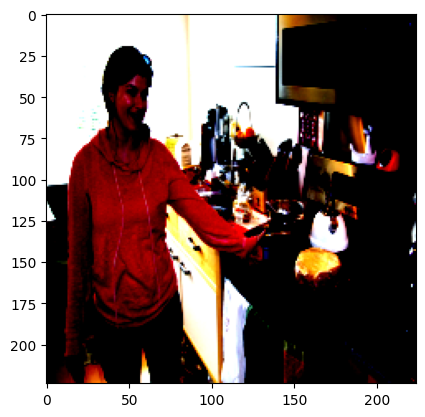

['A man standing on top of a tennis court holding a racquet.', 'A tennis player is waiting to compete on a tennis court.', 'A person that is wearing a visor and hold a tennis racket. ', 'A man stands on a tennis court, ready to play.', 'A man in shorts and a white visor in a tennis stance.']
A man in a blue shirt, blue hat and gray shorts playing tennis.


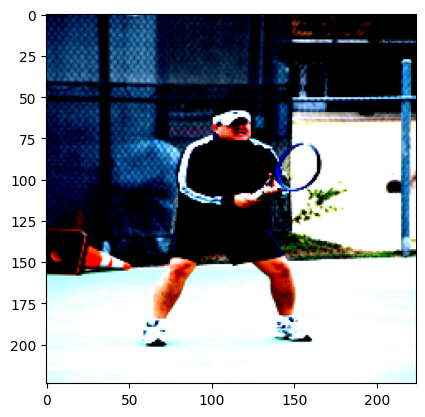

['An advertisement from A Christmas Wonderland store with several GE products.', "A page in a General Electric's catalog advertising Christmas ideas.", 'Electronics advertised on a paper for Christmas. ', 'an ad for General Electric with clocks and appliances on it', 'A various items such clocks and kitchen appliances are advertized. ']
A bathroom has red walls with yellow accents.


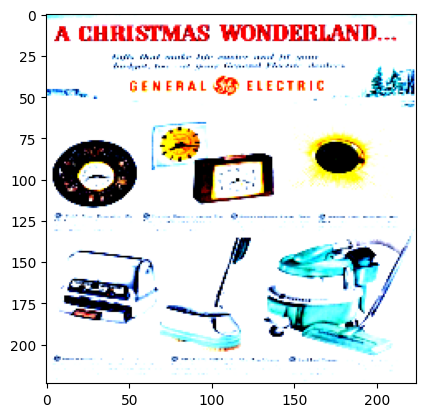

['A black dishwasher sitting next to a microwave.', 'The microwave is next to the dish washer underneath the counter. ', 'A dishwasher is seen in a kitchen setting.', 'An older kitchen with tan cabinets, black appliances, and faux granite countertops.', 'A closeup of a corner in a kitchen with a microwave and a dishwasher.']
A kitchen has a dining table with a lime green chair.


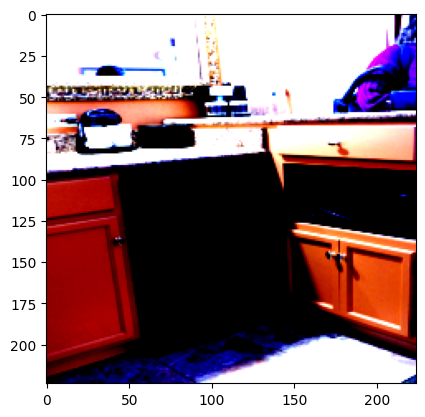

In [ ]:
for i in range(5):
  tmp = np.random.choice(range(len(img_test)))
  visualize_img(tmp)

# Part 3: Trying out different faiss index factory

['a man standing next to red checkered tables near trash cans.', 'A patio with trash cans attached to the fence.', 'A pleasant event with people sitting and standing as they enjoy themselves.', 'several men sitting down and one standing up next to red picnic tables.', 'A man talking on the phone by some benches']
A red cardinal bird is sitting on the side mirror of a car.


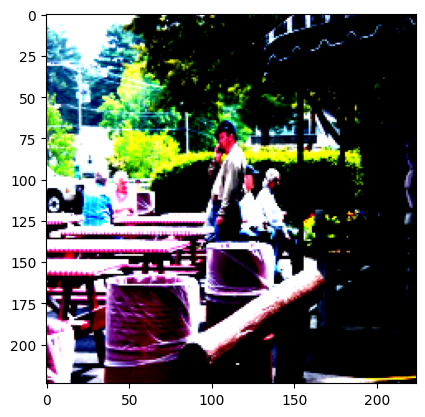

In [101]:
query_vector, predicted_captions, actual_captions = image_captioning(mode='index_flat_ip')
visualize_img(675)

['a man standing next to red checkered tables near trash cans.', 'A patio with trash cans attached to the fence.', 'A pleasant event with people sitting and standing as they enjoy themselves.', 'several men sitting down and one standing up next to red picnic tables.', 'A man talking on the phone by some benches']
A red cardinal bird is sitting on the side mirror of a car.


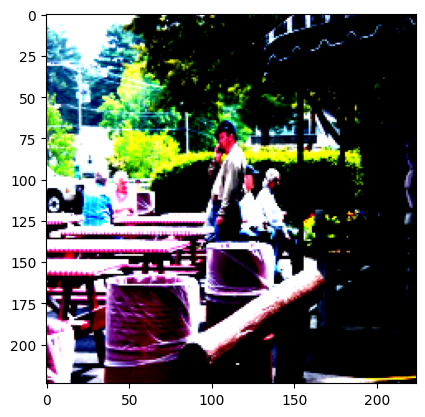

In [102]:
query_vector, predicted_captions, actual_captions = image_captioning(mode='index_hnsw_flat')
visualize_img(675)

## Observations:
- The captioning is consistent among different faiss index factories